# Facial Emotion Recognition

In [ ]:
# Import packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import torchvision
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import torch.optim as optim

import torch.nn.functional as F

import colorama
from colorama import Fore, Style

from torchsummary import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'DEVICE is : {DEVICE}')

DEVICE is : cuda


## Import Face Image Dataset

In [ ]:
dataset_path = "/kaggle/input/facial-emotion-recognition-dataset/processed_data"

# Analyze dataset structure to understand what files are available
def analyze_dataset(root_dir):
  structure = {}
  for root, dirs, files in os.walk(root_dir):
    rel_dir = os.path.relpath(root, root_dir)
    if rel_dir == '.':
      continue

    # Count files by extensions
    file_counts = {}
    for f in files:
      ext = os.path.splitext(f)[1].lower()
      if ext in file_counts:
        file_counts[ext] += 1
      else:
        file_counts[ext] = 1

    structure[rel_dir] = file_counts

  return structure

dataset_structure = analyze_dataset(dataset_path)
print("Dataset structure:")
for dir_path, file_types in dataset_structure.items():
  print(f"{dir_path}: {file_types}")

Dataset structure:
surprise: {'.jpg': 5920}
fear: {'.jpg': 5920}
angry: {'.jpg': 5920}
neutral: {'.jpg': 8166}
sad: {'.jpg': 6535}
disgust: {'.jpg': 5920}
happy: {'.jpg': 11398}


## Data Loading and Preprocessing

In [ ]:
def load_image_paths(dataset_path):
  """
  Load image paths with corresponding labels from the dataset structure
  """
  image_paths = []
  labels = []

  # Dictionary to map class folders to numeric labels
  class_map = {
      'surprise' : 0,
      'fear' : 1,
      'angry' : 2,
      'neutral' : 3,
      'sad' : 4,
      'disgust' : 5,
      'happy' : 6
  }

  # Iterate through each class folder
  for class_name, label in class_map.items():
    # Get all PNG images within the class
    png_path = os.path.join(dataset_path, class_name)

    if os.path.exists(png_path):
      png_files = glob.glob(os.path.join(png_path, '*.jpg'))
      # Add each image path with its label
      for img_path in png_files:
        image_paths.append(img_path)
        labels.append(label)
    else:
      print(f"Warning: Path {png_path} does not exist")

  return image_paths, labels

In [ ]:
# Get image paths and labels
image_paths, labels = load_image_paths(dataset_path)

print(f"Found {len(image_paths)} images across {len(set(labels))} classes")

# Check class distribution
class_names = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

label_counts = pd.Series(labels).value_counts().sort_index()
print("Class distribution:")
for i, count in enumerate(label_counts):
  print(f"{class_names[i]}: {count} images")

Found 49779 images across 7 classes
Class distribution:
surprise: 5920 images
fear: 5920 images
angry: 5920 images
neutral: 8166 images
sad: 6535 images
disgust: 5920 images
happy: 11398 images


## Visualize some image samples

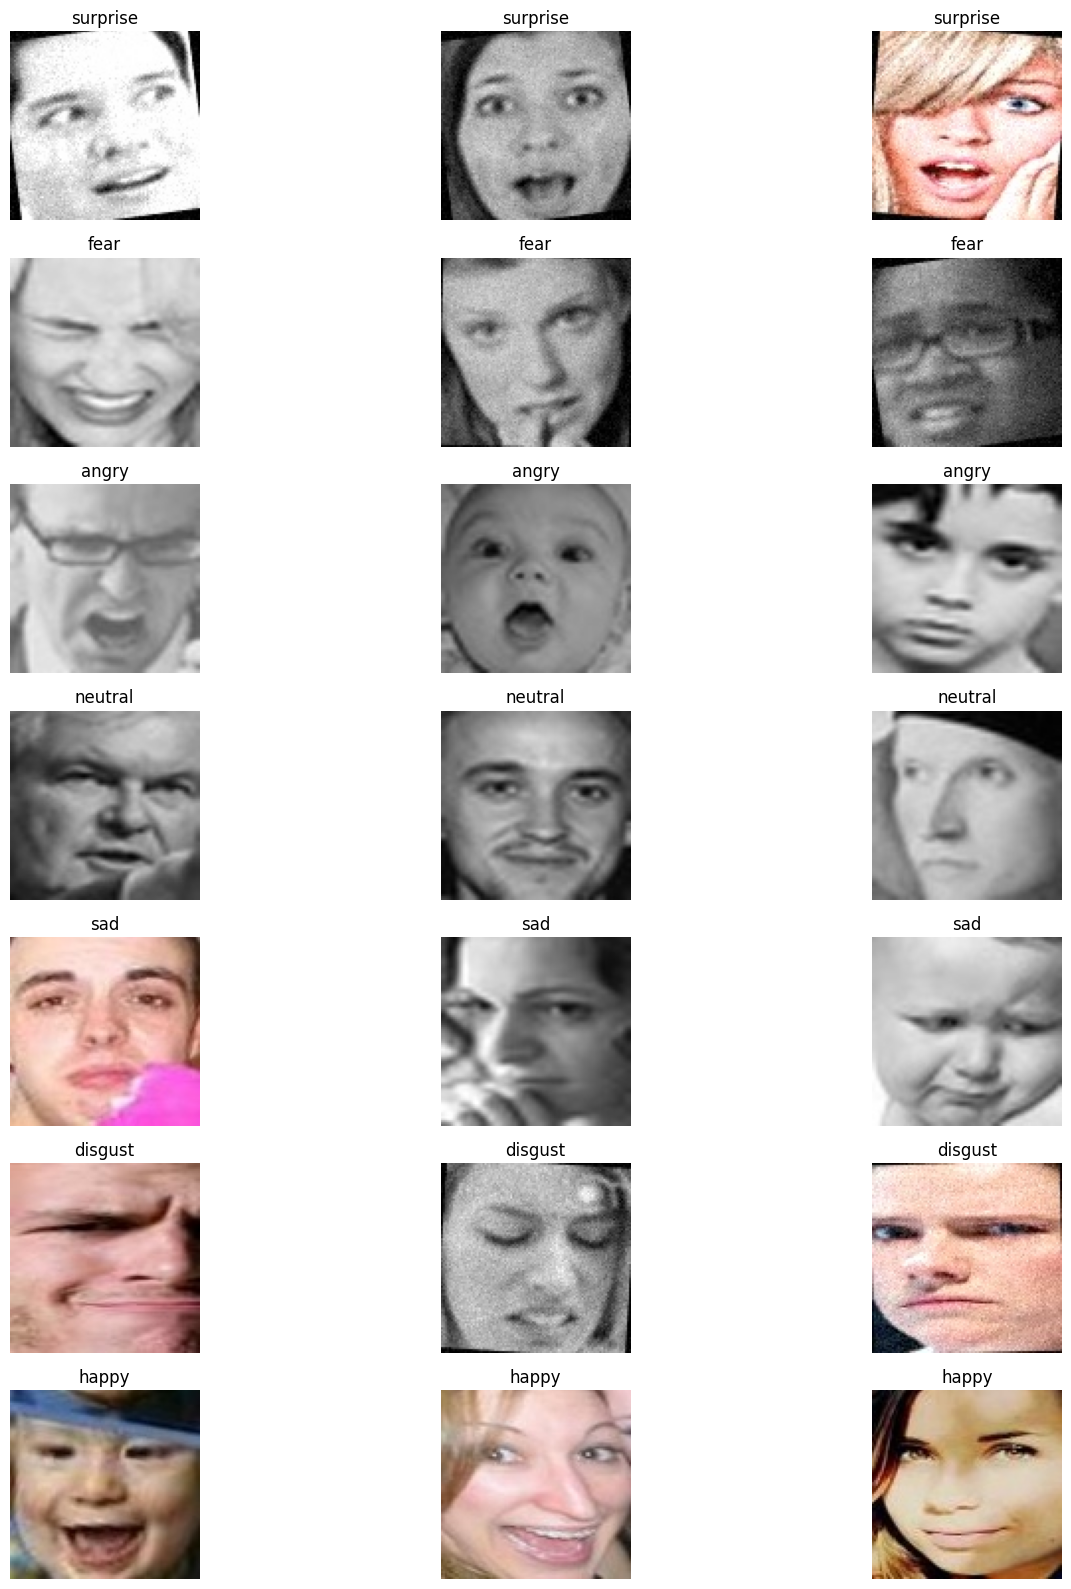

In [ ]:
def show_samples(image_paths, labels, n_samples=3):
  # Get random indices for each class
  indices = {}
  for i in range(7):
    class_indices = [idx for idx, label in enumerate(labels) if label == i]
    if len(class_indices) >= n_samples:
      indices[i] = np.random.choice(class_indices, n_samples, replace=False)
    else:
      indices[i] = class_indices

  # Create figure
  fig, axes = plt.subplots(7, n_samples, figsize=(15, 16))

  for i in range(7): # For each class
    for j in range(min(n_samples, len(indices[i]))): # For each sample
      idx = indices[i][j]
      img = Image.open(image_paths[idx])
      axes[i, j].imshow(img)
      axes[i, j].set_title(class_names[i])
      axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

# Show sample images
show_samples(image_paths, labels)

## Split into training and validation sets

In [ ]:
# Split in training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.15, random_state=42, stratify=labels
)

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")

Training set: 42312 images
Validation set: 7467 images


## Create custom dataset

In [ ]:
# Create a custom dataset class for brain CT images
class FaceDataset(Dataset):
  def __init__(self, image_paths, labels, transform=None):
    self.image_paths = image_paths
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    # Load image
    img_path = self.image_paths[idx]
    image = Image.open(img_path).convert('RGB')

    # Apply transformations if specified
    if self.transform:
      image = self.transform(image)
    else:
      # Basic conversion to tensor
      image = torch.tensor(np.array(image)).permute(2, 0, 1).float() / 255.0

    # Get label
    label = self.labels[idx]

    return image, label

## Image Augmentation

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the data to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the data to [-1, 1]
])

In [ ]:
# Create datasets
train_dataset = FaceDataset(train_paths, train_labels, transform=train_transform)
val_dataset = FaceDataset(val_paths, val_labels, transform=val_transform)

# Create data loaders
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Check a batch of data
for images, labels in train_loader:
  print(f"Batch shape: {images.shape}")
  print(f"Labels shape: {labels.shape}")
  break

Batch shape: torch.Size([40, 3, 256, 256])
Labels shape: torch.Size([40])


## Sample Image show after Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([40, 3, 256, 256])
Augmented Image:


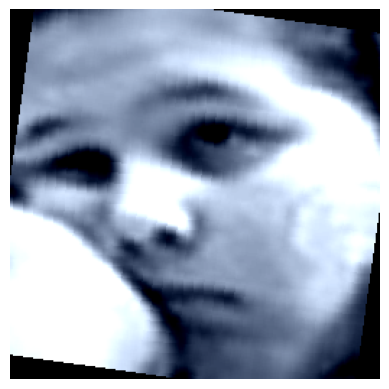

Label: neutral


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Test Image:


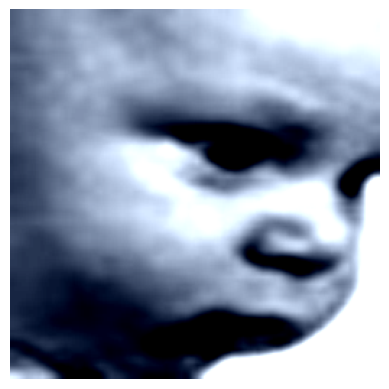

Label: surprise
Batch of Augmented Images:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


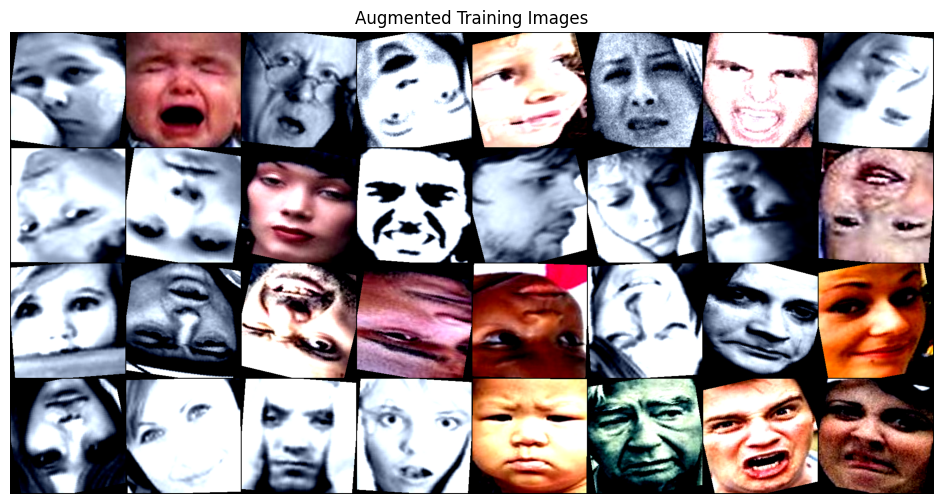

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: neutral sad surprise surprise happy angry angry happy sad angry neutral angry fear sad neutral happy neutral angry angry sad surprise fear sad happy sad happy angry surprise disgust sad angry disgust
Batch of Original Test Images:


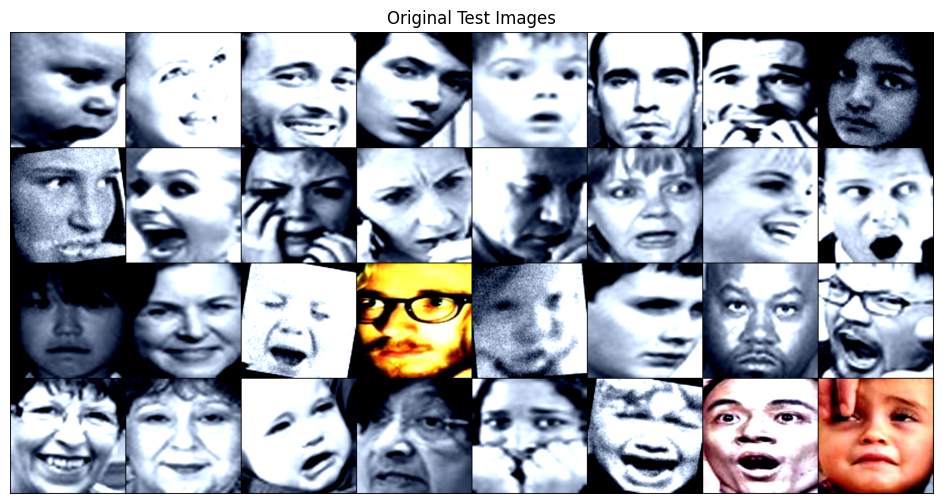

Labels: surprise happy happy neutral surprise neutral fear fear fear surprise fear fear fear fear happy surprise neutral happy fear neutral angry neutral neutral angry happy happy angry fear fear fear surprise sad


In [ ]:
# Function to show an image
def imshow(img):
  img = img / 2 + 0.5 # Unnormalize the image
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze(), cmap='gray')
  plt.axis('off')
  plt.show()

# 1. Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)

# 2. Show one augmented image
print('Augmented Image:')
imshow(images[0])
print('Label:', class_names[labels[0]])

# Get some random test images (without augmentation)
test_dataiter = iter(val_loader)
test_images, test_labels = next(test_dataiter)

# Show one original test image
print('Original Test Image:')
imshow(test_images[0])
print('Label:', class_names[test_labels[0]])

# 3. Visualizing Augmented Images

# Function to display a batch of images
def imshow_batch(img_batch, labels_batch, title):
  img_batch = img_batch / 2 + 0.5 # Unnormalize
  npimg = torchvision.utils.make_grid(img_batch, nrow=8)
  npimg = npimg.numpy()
  plt.figure(figsize=(12, 6))
  plt.imshow(np.transpose(npimg, (1, 2, 0)).squeeze())
  plt.title(title)
  plt.axis('off')
  plt.show()
  # Print labels
  print('Labels:', ' '.join(f'{class_names[labels_batch[j]]}' for j in range(len(labels_batch))))

# Display a batch of augmented images
print('Batch of Augmented Images:')
imshow_batch(images[:32], labels[:32], 'Augmented Training Images')

# Display a batch of original test images
print('Batch of Original Test Images:')
imshow_batch(test_images[:32], test_labels[:32], 'Original Test Images')

In [ ]:
# For loading in the device (GPU if available else CPU)
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dataloader, device):
    self.dataloader = dataloader
    self.device = device

  def __iter__(self):
    """Yeild a batch of data after moving it to device"""
    for b in self.dataloader:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dataloader)

# For moving data to device (CPU or GPU)
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

# Moving data into GPU, WrappedDataLoader
trainloader = DeviceDataLoader(train_loader, DEVICE)
validloader = DeviceDataLoader(val_loader, DEVICE)

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

torch.Size([40, 3, 256, 256])


In [ ]:
# For calculating the accuracy
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    #images, labels = images.to(DEVICE), labels.to(DEVICE) # move to GPU
    out = self(images)  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    images, labels = batch
    #images, labels = images.to(DEVICE), labels.to(DEVICE) # Move to GPU
    out = self(images) # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    acc = accuracy(out, labels) # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# Convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool:
    layers.append(nn.MaxPool2d(4))
  return nn.Sequential(*layers)

## Resnet Architecture

In [ ]:
# Resnet architecture
class CNN_NeuralNet(ImageClassificationBase):
  def __init__(self, in_channels, num_class):
    super().__init__()

    self.conv1 = ConvBlock(in_channels, 64)
    self.conv2 = ConvBlock(64, 128, pool=True)
    self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

    self.conv3 = ConvBlock(128, 256, pool=True)
    self.conv4 = ConvBlock(256, 512, pool=True)
    # self.conv5 = ConvBlock(256, 256, pool=True)
    # self.conv6 = ConvBlock(256, 512, pool=True)
    # self.conv7 = ConvBlock(512, 512, pool=True)

    self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

    self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    nn.Flatten(),
                                    nn.Linear(512, num_class))

  def forward(self, x): # x is the loaded batch
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    # out = self.conv5(out)
    # out = self.conv6(out)
    # out = self.conv7(out)
    out = self.res2(out) + out
    out = self.classifier(out)

    return out

In [ ]:
# Define the model and move it to the GPU
# 3 is the number of channels RGB
model = to_device(CNN_NeuralNet(3, len(class_names)), DEVICE)
model

CNN_NeuralNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inpl

In [ ]:
# For training
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  if optimizer is None:
    raise ValueError("Optimizer is not defined")
  if not optimizer.param_groups:
    raise ValueError("Optimizer has no param groups.")
  else:
    for param_group in optimizer.param_groups:
      return param_group['lr']

In [ ]:
%%time
history = [evaluate(model, validloader)]
history

CPU times: user 31.9 s, sys: 1.71 s, total: 33.6 s
Wall time: 34.3 s


[{'val_loss': 1.9505436420440674, 'val_acc': 0.14237473905086517}]


## Hyperparameters Function

* Its time to create a function that get epochs, learning rate, train and validation loader and optim functions...

* Clear GPU memory after PyTorch model training without restarting kernel with `torch.cuda.empty_cache()`

In [ ]:
def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = [] # For collecting the results

    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Scheduler for one cycle learning rate
    # Sets the learnng rat of each parameter group according to the 1cycle learning rate policy
    # The 1cycle policy anneals the learning rate from an initial learning rate to some
    # Maximum learning rate and then from that maximum learning rate to some minimum learning rate
    # Much lower than the initial learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr,
                                                epochs=epochs,
                                            steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            # Clip the gradients of an iterable of parameters at specified value
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Recording and updating learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
            # Validation

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    torch.save(model.state_dict(), 'resnet_model.pth')
    return history

## Train model

- Evaluate function added to history of model
- We can then define hyperparameters like number of epochs, learning rate
- We can update history with `fit_OneCycle` function (Adding two function together).
  

In [ ]:
num_epoch = 70
lr_rate = 0.007
grad_clip = 0.15
weight_decay = 1e-4
optims = torch.optim.Adam

history = fit_OneCycle(num_epoch, lr_rate, model, trainloader, validloader,
                      grad_clip=grad_clip,
                      weight_decay=weight_decay,
                      opt_func=optims)

Epoch 1/70:  41%|████      | 429/1058 [04:31<06:40,  1.57it/s]

In [ ]:
val_acc = []
val_loss = []
train_loss = []

for i in history:
    val_acc.append(i['val_acc'])
    val_loss.append(i['val_loss'])
    train_loss.append(i.get('train_loss'))

## Loss per Epochs curve

In [ ]:
epoch_count = range(1,71)

plt.figure(figsize=(14,6), dpi=200)
plt.plot(epoch_count, train_loss, 'r--', color= 'orangered')
plt.plot(epoch_count, val_loss, '--bo', color= 'green', linewidth='2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,71,3))
plt.show();

In [ ]:
epoch_count = range(1,71)
plt.figure(figsize=(14,6), dpi=200)
plt.plot(epoch_count, val_acc, '--bo', color='green', linewidth='2.5', label='line with marker')
plt.legend(['Val Acc'])
plt.title('Number of epochs & Acc')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,71,3))
plt.show();

## Visualize Model Predictions

In [ ]:
model.load_state_dict(torch.load("resnet_Model.pth"))

def visualize_predictions(model, dataloader, class_names, num_samples=20):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            # Store batch data
            all_images.extend(inputs.cpu())
            all_images.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            if len(all_images) >= num_samples:
                break

    # Limit to requested number of samples
    all_images = all_images[:num_samples]
    all_labels = all_labels[:num_samples]
    all_preds = all_preds[:num_samples]

    # Visualize
    fig, axes = plt.subplots(4, 5, figsize=(15, 10))
    axes = axes.flatten()

    for i, (img, label, pred) in enumerate(zip(all_images, all_labels, all_preds)):
        if i >= len(axes):
            break

        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Display
        axes[i].imshow(img)
        color = 'green' if label == pred else 'red'
        axes[i].set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}", color=color)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictios(model, validloader, class_names)